# 02. Exploratory Data Analysis (EDA)

## Objective
- Phân tích hành vi tiêu thụ điện
- Phát hiện các mô hình thời vụ

## 1. Setup and Load Dataset

In [4]:
# Get the parent directory and import the module
import os
import sys
sys.path.append(os.path.abspath('../'))
from src.data_loader import load_raw_data

import matplotlib.pyplot as plt

In [2]:
# Load the raw data
df = load_raw_data()
print("✅ Loaded")
print("Shape:", df.shape)

df.head()

👉 Loading: C:\Users\YOGA\Desktop\01_Time Series\PROJECT\Github\Electricity-Load-Diagrams\data\raw\electricity_data.parquet
✅ Data loaded successfully!
📊 Samples: 140256
👥 Number of customers: 370
🕒 Time span: 2011-01-01 00:15:00 → 2015-01-01 00:00:00
✅ Loaded
Shape: (140256, 370)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Time Series Visualization
- Chuỗi thời gian tổng
- Chuỗi theo consumer (mẫu đại diện)

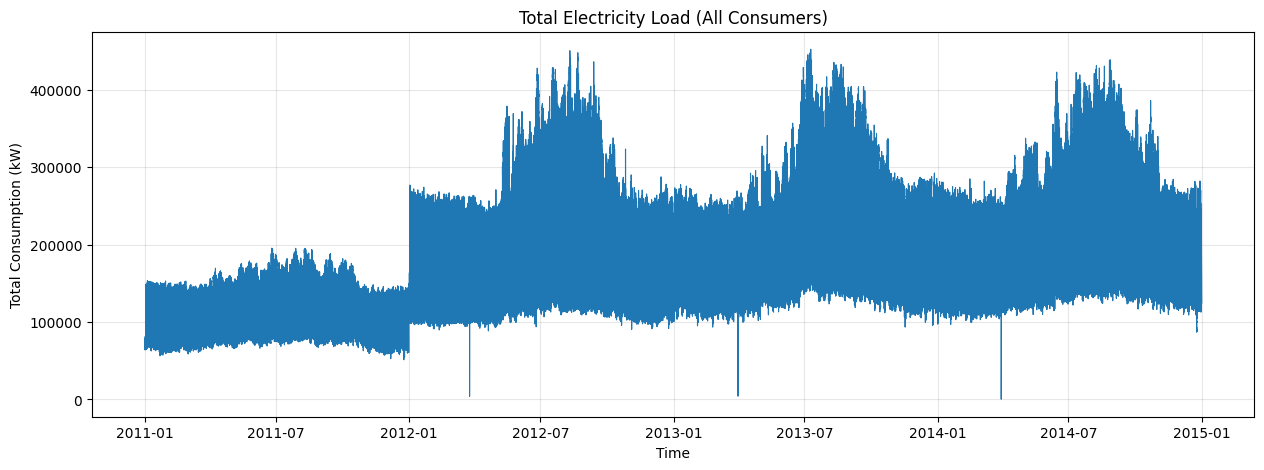

In [5]:
# chuỗi thời gian theo tổng 
df_total = df.sum(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(df_total, linewidth=0.8)
plt.title("Total Electricity Load (All Consumers)")
plt.xlabel("Time")
plt.ylabel("Total Consumption (kW)")
plt.grid(alpha=0.3)
plt.show()

## 3. Seasonality Analysis
### 3.1 Daily Seasonality
- Biểu đồ trung bình theo giờ

### 3.2 Weekly Seasonality
- Ngày trong tuần vs cuối tuần

### 3.3 Yearly Seasonality
- Biến động theo tháng / mùa

## 4. Load Distribution
- Histogram
- Boxplot

## 5. Statistical Summary
- Mean, Median, Std
- Min / Max

## 6. Key Insights
- Các mẫu thời vụ quan trọng
- Nhận dạng giờ cao điểm / thấp điểm

## 7. Conclusion
- Tóm tắt insight chính phục vụ modeling